In [17]:
# ====== Cell 1: Imports and Setup ======
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [18]:
# ====== Cell 2: Load MNIST Dataset ======
transform = transforms.Compose([
    transforms.ToTensor()  # converts to tensor and normalizes to [0,1]
])

mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_test  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Split training into train/validation
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(mnist_test, batch_size=128, shuffle=False)

print(f"Train: {len(train_dataset)}  Val: {len(val_dataset)}  Test: {len(mnist_test)}")


Train: 48000  Val: 12000  Test: 10000


In [19]:
# ====== Cell 3: β-VAE Definition (784 -> 512 -> 32 latent) ======
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: 784 -> 512
        self.fc_enc = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU()
        )
        # Separate layers for mean (mu) and log-variance (logvar)
        self.fc_mu     = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder: 32 -> 512 -> 784
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()   # output in [0,1]
        )

    def encode(self, x):
        # x: [B, 1, 28, 28]
        x = x.view(x.size(0), -1)       # [B, 784]
        h = self.fc_enc(x)              # [B, 512]
        mu = self.fc_mu(h)              # [B, latent_dim]
        logvar = self.fc_logvar(h)      # [B, latent_dim]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * eps
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        out = self.fc_dec(z)            # [B, 784]
        out = out.view(z.size(0), 1, 28, 28)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

model = BetaVAE(latent_dim=32).to(device)
print(model)


BetaVAE(
  (fc_enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc_dec): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [20]:
# ====== Cell 4: Loss and Optimizer (β-VAE loss) ======
criterion_recon = nn.MSELoss(reduction="mean")
beta = 1.0  # default β parameter

import torch.nn.functional as F

criterion_recon = nn.MSELoss(reduction="sum")  # not used directly, but okay
beta = 1.0  # target β

def beta_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    B = x.size(0)

    # Reconstruction loss: sum over pixels, then mean over batch
    recon_loss = F.mse_loss(recon_x, x, reduction="sum") / B

    # KL: sum over latent dims, then mean over batch
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # [B]
    kl_loss = torch.mean(kl)

    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss.detach().item(), kl_loss.detach().item()


optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [21]:
# ====== Cell 5: Training Loop ======
num_epochs = 40

train_total_losses = []
val_total_losses   = []

train_recon_losses = []
train_kl_losses    = []

val_recon_losses = []
val_kl_losses    = []

for epoch in range(num_epochs):
    # linear warmup of β from 0 -> 1 over first 10 epochs
    beta_current = beta * min(1.0, (epoch + 1) / 10.0)

    # ----- TRAIN -----
    model.train()
    running_total = 0.0
    running_recon = 0.0
    running_kl    = 0.0

    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        images = images.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(images)
        total_loss, recon_loss_val, kl_loss_val = beta_vae_loss(
            recon, images, mu, logvar, beta=beta_current
        )
        total_loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_total += total_loss.item() * batch_size
        running_recon += recon_loss_val * batch_size
        running_kl    += kl_loss_val * batch_size

    # compute epoch train losses
    train_total = running_total / len(train_loader.dataset)
    train_recon = running_recon / len(train_loader.dataset)
    train_kl    = running_kl / len(train_loader.dataset)

    train_total_losses.append(train_total)
    train_recon_losses.append(train_recon)
    train_kl_losses.append(train_kl)

    # ----- VALIDATION -----
    model.eval()
    running_total = 0.0
    running_recon = 0.0
    running_kl    = 0.0

    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            images = images.to(device)
            recon, mu, logvar = model(images)
            total_loss, recon_loss_val, kl_loss_val = beta_vae_loss(
                recon, images, mu, logvar, beta=beta_current
            )

            batch_size = images.size(0)
            running_total += total_loss.item() * batch_size
            running_recon += recon_loss_val * batch_size
            running_kl    += kl_loss_val * batch_size

    val_total = running_total / len(val_loader.dataset)
    val_recon = running_recon / len(val_loader.dataset)
    val_kl    = running_kl / len(val_loader.dataset)

    val_total_losses.append(val_total)
    val_recon_losses.append(val_recon)
    val_kl_losses.append(val_kl)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Total: {train_total:.6f}  Val Total: {val_total:.6f}  "
          f"(Train recon: {train_recon:.6f}, KL: {train_kl:.6f}, "
          f"beta: {beta_current:.3f})")


Epoch 1/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 415.53it/s]


Epoch [1/40] Train Total: 34.976082  Val Total: 20.795048  (Train recon: 31.925954, KL: 30.501287, beta: 0.100)


Epoch 2/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 444.79it/s]


Epoch [2/40] Train Total: 21.433941  Val Total: 19.651296  (Train recon: 14.880282, KL: 32.768294, beta: 0.200)


Epoch 3/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 443.66it/s]


Epoch [3/40] Train Total: 21.848167  Val Total: 21.262708  (Train recon: 13.300326, KL: 28.492802, beta: 0.300)


Epoch 4/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 442.12it/s]


Epoch [4/40] Train Total: 23.429038  Val Total: 23.077380  (Train recon: 13.454109, KL: 24.937322, beta: 0.400)


Epoch 5/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 439.11it/s]


Epoch [5/40] Train Total: 25.120402  Val Total: 25.038066  (Train recon: 14.096278, KL: 22.048247, beta: 0.500)


Epoch 6/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 437.26it/s]


Epoch [6/40] Train Total: 26.678850  Val Total: 26.569485  (Train recon: 14.912076, KL: 19.611290, beta: 0.600)


Epoch 7/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 436.57it/s]


Epoch [7/40] Train Total: 28.119268  Val Total: 28.077296  (Train recon: 15.785050, KL: 17.620312, beta: 0.700)


Epoch 8/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 428.77it/s]


Epoch [8/40] Train Total: 29.427178  Val Total: 29.387757  (Train recon: 16.641395, KL: 15.982229, beta: 0.800)


Epoch 9/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 437.60it/s]


Epoch [9/40] Train Total: 30.670091  Val Total: 30.717565  (Train recon: 17.504221, KL: 14.628745, beta: 0.900)


Epoch 10/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 437.28it/s]


Epoch [10/40] Train Total: 31.785429  Val Total: 31.813467  (Train recon: 18.343718, KL: 13.441711, beta: 1.000)


Epoch 11/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 399.06it/s]


Epoch [11/40] Train Total: 31.559156  Val Total: 31.630722  (Train recon: 18.312099, KL: 13.247056, beta: 1.000)


Epoch 12/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 410.69it/s]


Epoch [12/40] Train Total: 31.364229  Val Total: 31.539220  (Train recon: 18.231994, KL: 13.132235, beta: 1.000)


Epoch 13/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 423.70it/s]


Epoch [13/40] Train Total: 31.222003  Val Total: 31.299682  (Train recon: 18.132795, KL: 13.089209, beta: 1.000)


Epoch 14/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 418.41it/s]


Epoch [14/40] Train Total: 31.098715  Val Total: 31.187791  (Train recon: 18.073022, KL: 13.025694, beta: 1.000)


Epoch 15/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 422.47it/s]


Epoch [15/40] Train Total: 30.922020  Val Total: 31.088354  (Train recon: 17.955318, KL: 12.966702, beta: 1.000)


Epoch 16/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 420.69it/s]


Epoch [16/40] Train Total: 30.837135  Val Total: 30.924890  (Train recon: 17.880236, KL: 12.956899, beta: 1.000)


Epoch 17/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 401.69it/s]


Epoch [17/40] Train Total: 30.755293  Val Total: 30.909094  (Train recon: 17.812311, KL: 12.942983, beta: 1.000)


Epoch 18/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 419.27it/s]


Epoch [18/40] Train Total: 30.681608  Val Total: 30.812194  (Train recon: 17.764709, KL: 12.916899, beta: 1.000)


Epoch 19/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 420.35it/s]


Epoch [19/40] Train Total: 30.559705  Val Total: 30.787492  (Train recon: 17.674202, KL: 12.885503, beta: 1.000)


Epoch 20/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 381.67it/s]


Epoch [20/40] Train Total: 30.493795  Val Total: 30.755873  (Train recon: 17.605607, KL: 12.888188, beta: 1.000)


Epoch 21/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 415.22it/s]


Epoch [21/40] Train Total: 30.412375  Val Total: 30.654072  (Train recon: 17.549916, KL: 12.862459, beta: 1.000)


Epoch 22/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 412.53it/s]


Epoch [22/40] Train Total: 30.347941  Val Total: 30.607751  (Train recon: 17.509987, KL: 12.837954, beta: 1.000)


Epoch 23/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 393.86it/s]


Epoch [23/40] Train Total: 30.304775  Val Total: 30.522811  (Train recon: 17.456653, KL: 12.848122, beta: 1.000)


Epoch 24/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 369.83it/s]


Epoch [24/40] Train Total: 30.211321  Val Total: 30.495845  (Train recon: 17.418853, KL: 12.792469, beta: 1.000)


Epoch 25/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 407.18it/s]


Epoch [25/40] Train Total: 30.124690  Val Total: 30.299694  (Train recon: 17.330678, KL: 12.794012, beta: 1.000)


Epoch 26/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 409.22it/s]


Epoch [26/40] Train Total: 30.119354  Val Total: 30.290636  (Train recon: 17.321651, KL: 12.797703, beta: 1.000)


Epoch 27/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 411.01it/s]


Epoch [27/40] Train Total: 30.025241  Val Total: 30.204759  (Train recon: 17.257865, KL: 12.767376, beta: 1.000)


Epoch 28/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 413.65it/s]


Epoch [28/40] Train Total: 29.948759  Val Total: 30.267481  (Train recon: 17.197665, KL: 12.751094, beta: 1.000)


Epoch 29/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 414.53it/s]


Epoch [29/40] Train Total: 29.918778  Val Total: 30.109809  (Train recon: 17.168869, KL: 12.749910, beta: 1.000)


Epoch 30/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 414.54it/s]


Epoch [30/40] Train Total: 29.862512  Val Total: 30.168093  (Train recon: 17.141472, KL: 12.721041, beta: 1.000)


Epoch 31/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 402.24it/s]


Epoch [31/40] Train Total: 29.778378  Val Total: 29.972878  (Train recon: 17.071967, KL: 12.706411, beta: 1.000)


Epoch 32/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 412.07it/s]


Epoch [32/40] Train Total: 29.694897  Val Total: 30.006990  (Train recon: 17.019332, KL: 12.675565, beta: 1.000)


Epoch 33/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 388.16it/s]


Epoch [33/40] Train Total: 29.673601  Val Total: 29.954309  (Train recon: 17.003954, KL: 12.669647, beta: 1.000)


Epoch 34/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 413.22it/s]


Epoch [34/40] Train Total: 29.630050  Val Total: 29.915510  (Train recon: 16.976440, KL: 12.653611, beta: 1.000)


Epoch 35/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 416.31it/s]


Epoch [35/40] Train Total: 29.559799  Val Total: 29.776030  (Train recon: 16.919064, KL: 12.640736, beta: 1.000)


Epoch 36/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 388.37it/s]


Epoch [36/40] Train Total: 29.548834  Val Total: 29.828857  (Train recon: 16.880072, KL: 12.668761, beta: 1.000)


Epoch 37/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 387.63it/s]


Epoch [37/40] Train Total: 29.499537  Val Total: 29.743628  (Train recon: 16.875611, KL: 12.623925, beta: 1.000)


Epoch 38/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 410.74it/s]


Epoch [38/40] Train Total: 29.454456  Val Total: 29.696145  (Train recon: 16.816108, KL: 12.638347, beta: 1.000)


Epoch 39/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 415.58it/s]


Epoch [39/40] Train Total: 29.389981  Val Total: 29.633176  (Train recon: 16.782072, KL: 12.607909, beta: 1.000)


Epoch 40/40 - Val: 100%|██████████| 94/94 [00:00<00:00, 413.76it/s]

Epoch [40/40] Train Total: 29.373899  Val Total: 29.643534  (Train recon: 16.770764, KL: 12.603135, beta: 1.000)


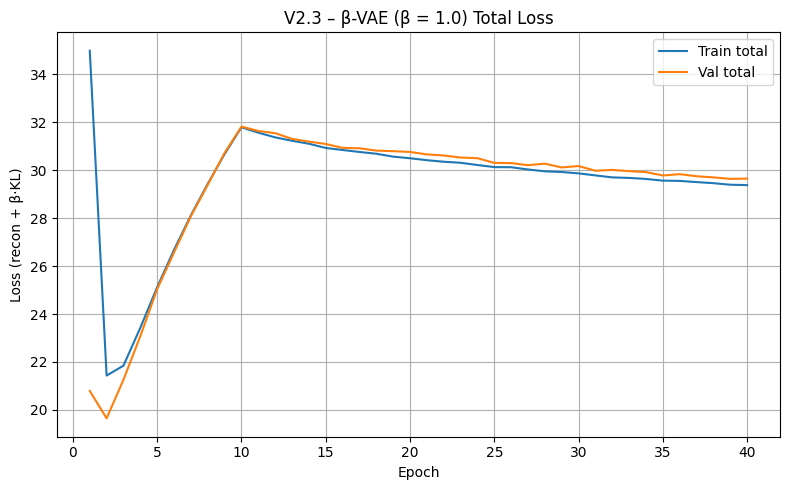

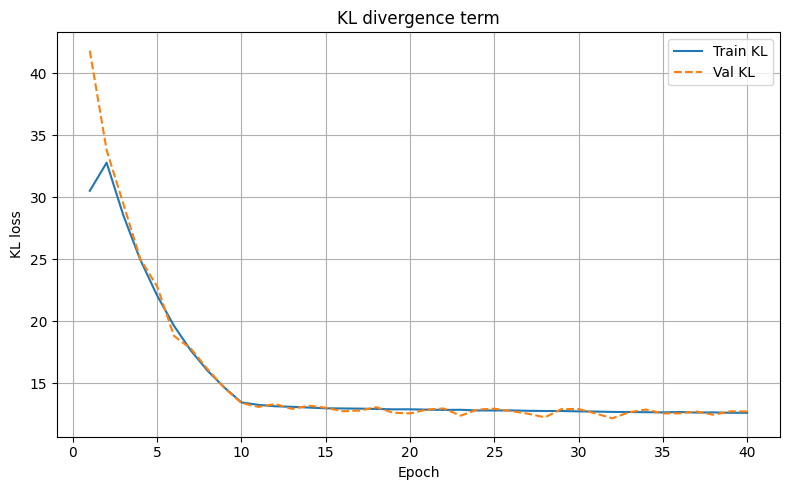

In [22]:
# ====== Cell 6: Plot Loss Curves (Train vs Validation) ======
epochs = np.arange(1, num_epochs + 1)

# --- 1) Total loss ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_total_losses, label="Train total")
plt.plot(epochs, val_total_losses, label="Val total")
plt.xlabel("Epoch")
plt.ylabel("Loss (recon + β·KL)")
plt.title(f"V2.3 – β-VAE (β = {beta}) Total Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2) Reconstruction vs KL (separate subplot) ---
plt.figure(figsize=(8, 5))


plt.plot(epochs, train_kl_losses, label="Train KL")
plt.plot(epochs, val_kl_losses,   label="Val KL", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("KL loss")
plt.title("KL divergence term")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



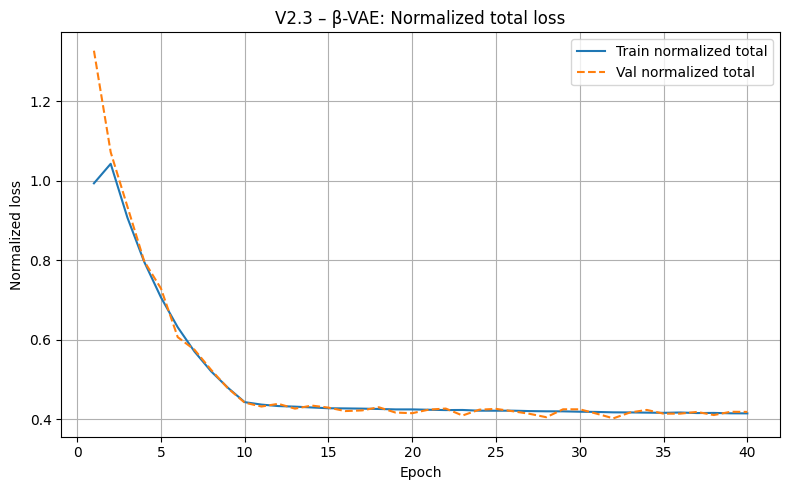

In [23]:
train_total_norm = []
val_total_norm   = []

for t_recon, t_kl, v_recon, v_kl in zip(
    train_recon_losses, train_kl_losses, val_recon_losses, val_kl_losses
):
    # per-pixel recon + KL scaled by latent dim
    tr = (t_recon / (28*28)) + (t_kl / 32)
    vr = (v_recon / (28*28)) + (v_kl / 32)
    train_total_norm.append(tr)
    val_total_norm.append(vr)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_total_norm, label="Train normalized total")
plt.plot(epochs, val_total_norm,   label="Val normalized total", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Normalized loss")
plt.title("V2.3 – β-VAE: Normalized total loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


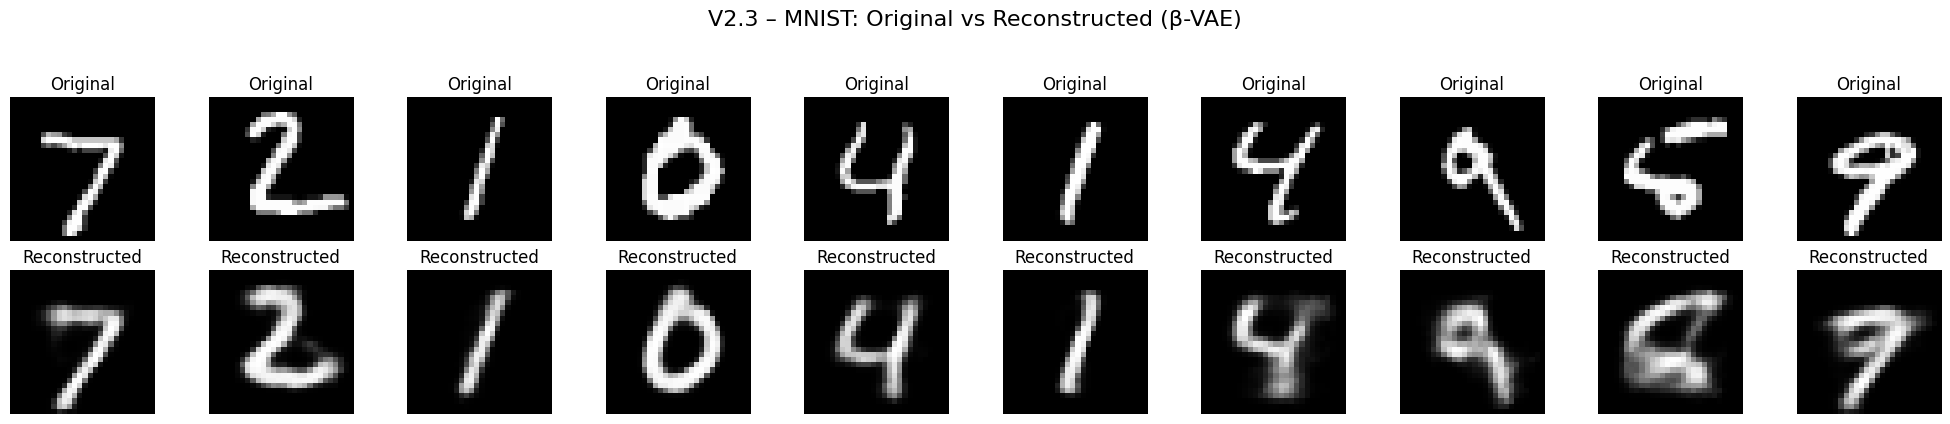

In [24]:
# ====== Cell 7: Original vs Reconstructed MNIST Test Images ======
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    recon, mu, logvar = model(images)

# Move to CPU for plotting
images_np = images.cpu().numpy()
recon_np  = recon.cpu().numpy()

n = 10  # number of examples to show
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images_np[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_np[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.suptitle("V2.3 – MNIST: Original vs Reconstructed (β-VAE)", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


In [25]:
# ====== Cell 8: Save Model ======
torch.save(model.state_dict(), "autoencoder_mnist_v2_3.pth")
print("Model saved to autoencoder_mnist_v2_3.pth")


Model saved to autoencoder_mnist_v2_3.pth
